# Chest X-Ray (Pneumonia): Deeper CNN Network 

Deeper CNN Network + some complications + class balancing + Strong Data augmentation

Similar 021 but solving the class balancing issue


In [1]:
import pandas as pd       
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
%matplotlib inline

pd.options.display.max_colwidth = 100

import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # to avoid warning messages

from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob
import cv2

from tensorflow.random import set_seed
set_seed(42)

import warnings
warnings.filterwarnings('ignore')

In [2]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

In [3]:
# folder structure 
#Notebook
#    !------ chest_xray_data
#                  !-------------train
#                  !-------------test
#                  !-------------validation
#
main_path = "./chest_xray_data/"

train_path = os.path.join(main_path,"TRAIN")
test_path = os.path.join(main_path,"TEST")
val_path  = os.path.join(main_path,"VALIDATION")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

val_normal = glob.glob(val_path+"/NORMAL/*.jpeg")
val_pneumonia = glob.glob(val_path+"/PNEUMONIA/*.jpeg")

COUNT_NORMAL = len(train_normal)+len(test_normal)+len(val_normal)
COUNT_PNEUMONIA = len(train_pneumonia)+len(test_pneumonia)+len(val_pneumonia)

In [4]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), 
                        columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), 
                       columns = ['class'])
df_test['image'] = [x for x in test_list]

val_list = [x for x in val_normal]
val_list.extend([x for x in val_pneumonia])

df_val = pd.DataFrame(np.concatenate([['Normal']*len(val_normal) , ['Pneumonia']*len(val_pneumonia)]), 
                      columns = ['class'])
df_val['image'] = [x for x in val_list]

train_df = df_train
test_df = df_test
val_df = df_val

### Data Preparation


In [5]:
print ('shapes. Train: ',train_df.shape, 'val : ', val_df.shape, 'test : ',df_test.shape)
# https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c

train_datagen = ImageDataGenerator(rescale=1/255.,
                            rotation_range=20,
                            width_shift_range=0.1,
                            shear_range=10,
                            horizontal_flip = True,
                            fill_mode = 'nearest',
                            zoom_range=0.2
#                           samplewise_center=True
)

val_datagen  = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             #directory=train_path, #dataframe contains the full paths
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            #directory=train_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = test_datagen.flow_from_dataframe(df_test,
                                            #directory=test_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

shapes. Train:  (4099, 2) val :  (879, 2) test :  (878, 2)
Found 4099 validated image filenames belonging to 2 classes.
Found 879 validated image filenames belonging to 2 classes.
Found 878 validated image filenames belonging to 2 classes.


## Class balancing using class weight parameter in keras

In [6]:
initial_bias = np.log([COUNT_PNEUMONIA / COUNT_NORMAL])
print("Initial bias: {:.5f}".format(initial_bias[0]))

TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))



Initial bias: 0.99299
Weight for class 0: 1.85
Weight for class 1: 0.69


### CNN
Data is ready. Now we define the CNN network and train 

In [7]:
#Setting callbakcs

initial_learning_rate = 0.015
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.0000001,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 0.0001, 
    min_lr = 0.00001,
    cooldown = 0,                               
    verbose = 1
) 

Let’s define our first model ‘from scratch’ and see how it performs.

In [8]:
def get_model():
    
    # CNN Layers
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Block One
    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    # Block Two
    x = layers.Conv2D(filters=32, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)
    
    # Block Three
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.4)(x)

    # MLP - Classification layers
    
    #x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [9]:
keras.backend.clear_session()

model = get_model()
model.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=0.00003), metrics='binary_accuracy')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 222, 222, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 16)      0     

In [10]:
history = model.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          validation_data=ds_val,
          class_weight=class_weight,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));


Epoch 1/50
128/128 [==============================] - 214s 2s/step - loss: 0.6661 - binary_accuracy: 0.6489 - val_loss: 0.6153 - val_binary_accuracy: 0.7292 - lr: 3.0000e-05
Epoch 2/50
128/128 [==============================] - 220s 2s/step - loss: 0.4854 - binary_accuracy: 0.7641 - val_loss: 0.8824 - val_binary_accuracy: 0.7292 - lr: 3.0000e-05
Epoch 3/50
129/128 [==============================] - ETA: -2s - loss: 0.4018 - binary_accuracy: 0.8258
Epoch 3: ReduceLROnPlateau reducing learning rate to 1e-05.
128/128 [==============================] - 422s 3s/step - loss: 0.4018 - binary_accuracy: 0.8258 - val_loss: 1.0774 - val_binary_accuracy: 0.7292 - lr: 3.0000e-05
Epoch 4/50
128/128 [==============================] - 362s 3s/step - loss: 0.3491 - binary_accuracy: 0.8512 - val_loss: 0.9154 - val_binary_accuracy: 0.7292 - lr: 1.0000e-05
Epoch 5/50
128/128 [==============================] - 346s 3s/step - loss: 0.3317 - binary_accuracy: 0.8639 - val_loss: 0.4458 - val_binary_accuracy: 0

## Measuring the accuracy of the CNN Network

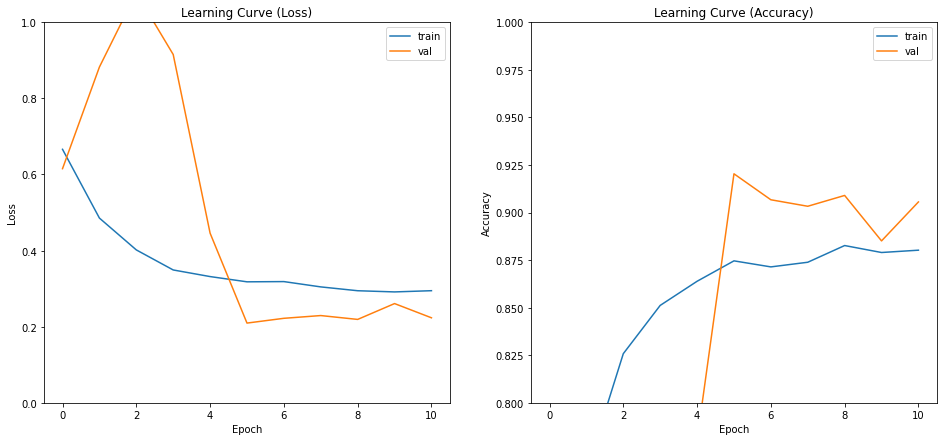

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,7))
sns.lineplot(x = history.epoch, y = history.history['loss'], ax=ax1)
sns.lineplot(x = history.epoch, y = history.history['val_loss'], ax=ax1)
ax1.set_title('Learning Curve (Loss)')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylim(0, 1)
ax1.legend(['train', 'val'], loc='best')
#
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'], ax=ax2)
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'], ax=ax2)
ax2.set_title('Learning Curve (Accuracy)')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylim(0.80, 1.0)
ax2.legend(['train', 'val'], loc='best')
plt.show()

In [12]:
score = model.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.20949001610279083
Val accuracy: 0.9203640222549438


In [13]:
score = model.evaluate(ds_test, verbose = 0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.21394149959087372
Test accuracy: 0.9259681105613708


## Confusion Matrix and ROC Curve

In [14]:
num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

In [15]:
ds_test.reset()
predictions = model.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels= np.where(predictions>0.5, 1, 0)

In [16]:
print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))

Test Accuracy:  0.9259681093394078


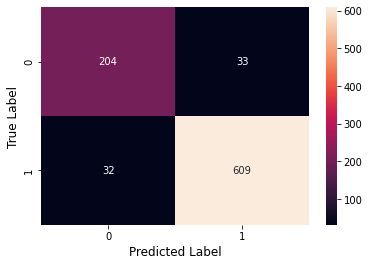

In [17]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [18]:
print(metrics.classification_report(Y_test, pred_labels, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       237
           1       0.95      0.95      0.95       641

    accuracy                           0.93       878
   macro avg       0.91      0.91      0.91       878
weighted avg       0.93      0.93      0.93       878



ROC_AUC:  0.9624992594640494


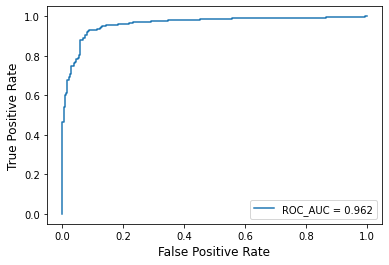

In [19]:
roc_auc = metrics.roc_auc_score(Y_test, predictions)
print('ROC_AUC: ', roc_auc)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

In [20]:
#EOF